In [ ]:
! pip install -r requirements.txt

  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0


: 

In [1]:
from finetunning_v2.data_manager import DataManager
from finetunning_v2.tokenizer import DataTokenizer
from finetunning_v2.mt5_lora import build_mt5_lora
from finetunning_v2.data_collator import DataCollatorT5
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer
from finetunning_v2.callbacks import (
    PrintExamplesCallback,
    PerplexityCallback,
    MemoryCallback,
    GradNormCallback,
    LearningRateCallback
)

: 

# 1. Entrenamiento con Train Entero

In [7]:
dm = DataManager(languages=['en', 'am', 'ar', 'de', 'es', 'hi', 'ru', 'uk', 'zh'])
dm.load_main_dataset()
dm.compute_overlap_feature()
dm.stratified_split(stratify_by=["language"])  # como acordamos
dm.create_curriculum_datasets()  # easy/medium/hard/full a nivel texto

# 2. Tokenizer
dtok = DataTokenizer(
    tokenizer_name="google/mt5-base",
    prefix="detoxify_keep_meaning: ",
    max_input_length=128,
    max_target_length=128,
    logger=dm.logger
)

tokenized_splits = dtok.tokenize_splits(dm.splits)
train_dataset = tokenized_splits["train"]
eval_dataset = tokenized_splits["val"]

# 3. Collator
collator = DataCollatorT5(tokenizer=dtok.tokenizer)

# 4. Model + LoRA
model = build_mt5_lora(base_model_name="google/mt5-base", device="cuda")

# 5. TrainingArguments (los que definimos antes)
training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5_detox_baseline",
    overwrite_output_dir=True,
    learning_rate=2e-4,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=10,
    logging_dir="./logs",
    logging_steps=50,
    log_level="info",
    save_total_limit=4,
    save_strategy="epoch",
    eval_strategy="epoch",
    predict_with_generate=True,
    generation_max_length=128,
    fp16=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

# 6. Trainer (aquí enchufarías también los callbacks que definimos)
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=dtok.tokenizer,
    data_collator=collator,
    callbacks=[
        PrintExamplesCallback(dtok.tokenizer, every_steps=50),
        PerplexityCallback(),
        MemoryCallback(),
        GradNormCallback(every_steps=50),
        LearningRateCallback(),
    ]
)

[11:14:57] [INFO] Inicializando DataManager para idiomas: ['en', 'am', 'ar', 'de', 'es', 'hi', 'ru', 'uk', 'zh']
loading file spiece.model from cache at C:\Users\mario\.cache\huggingface\hub\models--google--mt5-base\snapshots\2eb15465c5dd7f72a8f7984306ad05ebc3dd1e1f\spiece.model
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\mario\.cache\huggingface\hub\models--google--mt5-base\snapshots\2eb15465c5dd7f72a8f7984306ad05ebc3dd1e1f\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\mario\.cache\huggingface\hub\models--google--mt5-base\snapshots\2eb15465c5dd7f72a8f7984306ad05ebc3dd1e1f\tokenizer_config.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at C:\Users\mario\.cache\huggingface\hub\models--google--mt5-base\snapshots\2eb15465c5dd7f72a8f7984306ad05ebc3dd1e1f\config.json
Model config MT5Co

Tokenizing dataset (num_proc=4):   0%|          | 0/2880 [00:00<?, ? examples/s]

[11:15:50] [INFO]  → Tokenizing split `val` (360 samples)
[11:15:50] [INFO] Tokenizing dataset with 360 samples...


Tokenizing dataset (num_proc=4):   0%|          | 0/360 [00:00<?, ? examples/s]

[11:16:05] [INFO]  → Tokenizing split `test` (360 samples)
[11:16:05] [INFO] Tokenizing dataset with 360 samples...


Tokenizing dataset (num_proc=4):   0%|          | 0/360 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\mario\.cache\huggingface\hub\models--google--mt5-base\snapshots\2eb15465c5dd7f72a8f7984306ad05ebc3dd1e1f\config.json
Model config MT5Config {
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "mt5",
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "transformers_version": "4.57.1",
  "use_cache": true,
  "vocab_size": 250112
}

loading weights file pytorch_model.b

AssertionError: Torch not compiled with CUDA enabled

In [6]:
trainer.train()

***** Running training *****
  Num examples = 2,880
  Num Epochs = 10
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 3,600
  Number of trainable parameters = 1,769,472
c:\Users\mario\anaconda3\envs\nlp2\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [12]:
import pandas as pd

results = pd.read_csv("modelos/finetune_v2_1/test_results_batch.csv")

results

,toxic,gold_neutral,predicted_neutral
0,detoxify_keep_meaning: wir brauchen das scheiß...,wir brauchen das #Europa nicht ich bin #Deutsc...,Wir brauchen das scheiß #Europa nicht ich bin ...
1,detoxify_keep_meaning: I HATE YOU for deliting...,I dislike you for deleting my pages. Stay away...,I HATE YOU for deliting pages stay away from m...
2,detoxify_keep_meaning: До деяких людей не вини...,"До деяких людей не виникає інших питань, окрім...","До деяких людей не виникає інших питань, окрім..."
3,detoxify_keep_meaning: तू कहा अपना झोपड़ा मरवा...,तू अब कहां अपनी इज्जत से खिलवाड़ करवा रही है ?,तू कहा अपना झोपड़ा मरवा रही है मादरचोद कूत्ती ?
4,detoxify_keep_meaning: ты сама то что сделала?...,Ты сама то что сделала? Ничего ты не сделала,Ты сама то что сделала? ни хера ты не сделала
...,...,...,...
355,detoxify_keep_meaning: A su vez que no es lo m...,A su vez que no es lo mismo ser cristiano que ...,A su vez que no es lo mismo ser cristiano que ...
356,detoxify_keep_meaning: 全部共同特点:太丑了,全部共同特点:太不符合我个人的审美了,全部共同特点:太丑了
357,detoxify_keep_meaning: веселись сегодня ептить...,"Веселись сегодня, удрученный ты наш)))",сегодня веселись сегодня ептить удручённый ты ...
358,detoxify_keep_meaning: لا لا لا الحكم ده غبي ا...,لا لا لا الحكم ده جاهل اوي كده ليه,لا لا لا الحكم ده غبي اوي كده ليه


In [13]:
results_modified = results.copy()

results_modified['toxic'] = results_modified['toxic'].apply(lambda x: x.replace("detoxify_keep_meaning: ", "").strip())

results_modified['equals'] = results_modified.apply(lambda row: row['toxic'].lower() == row['predicted_neutral'].lower(), axis=1)

results_modified['equals'].value_counts()

equals
True     288
False     72
Name: count, dtype: int64

Text(0, 0.5, 'Count')

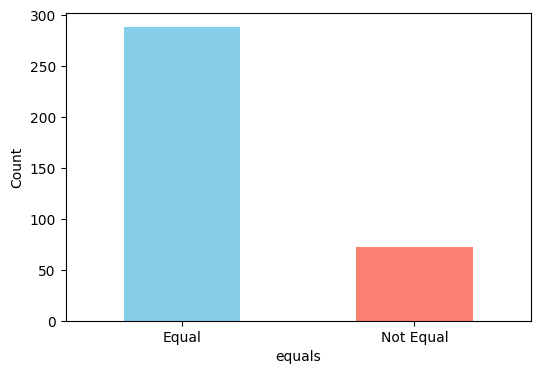

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
results_modified['equals'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.xticks(ticks=[0, 1], labels=['Equal', 'Not Equal'], rotation=0)
plt.ylabel('Count')


In [14]:
results_modified[results_modified['equals'] == False]

,toxic,gold_neutral,predicted_neutral,equals
14,"мразь тебя нужно вывести за грань , захрибетни...","тебя нужно вывести за грань , ешь с рук этих у...","Человек тебя нужно вывести за грань , захрибет...",False
16,"piss me off , fuckin jerk , get on my nerves .",get on my nerves,"Pis me off , fuckin jerk , get on my nerves .",False
25,"вже майже четверта, а я не сплю, блять","вже майже четверта, а я не сплю, що за","Вже майже четверта, а я не сплю",False
33,वाह भेनचोद वाह ...एक आदमी को नीचे गिराने के लि...,वाह भाई वाह ... एक आदमी को नीचा गिराने के लिए ...,वाह ...एक आदमी को नीचे गिराने के लिए कितने लोग...,False
35,"кошмар, руки бы оторвать. придурки .:o",ужасно!,"Комар, руки бы оторвать. придурки .:o",False
...,...,...,...,...
333,boeing is behaving exactly like any greedy bul...,Boeing is behaving unfairly,bully is behaving exactly like any bully would .,False
334,"Має дві роботи, але вкрай ниє, яка у нас хрено...","Має дві роботи, але вкрай ниє, яка у нас хрено...","Має дві роботи, але вкрай ниє, яка у нас хрено...",False
335,Der dumme Deutsche hat gewählt er läuft freiwi...,Der Deutsche hat gewählt er läuft freiwillig z...,Der dumme Deutsche hat gewählt er läuft freiwi...,False
352,this is a fuckingtzu tactic for shits sake .,that's a bad tactic,This is a tactic for shits sake .,False


In [11]:
# calculate the overlap between toxic and predicted_neutral for the rows where they are not equal
results_modified['overlap_toxic'] = results_modified.apply(lambda row: len(set(row['toxic'].split()).intersection(set(row['predicted_neutral'].split()))) / max(len(set(row['toxic'].split())), len(set(row['predicted_neutral'].split()))), axis=1)
results_modified['overlap_neutral'] = results_modified.apply(lambda row: len(set(row['toxic'].split()).intersection(set(row['predicted_neutral'].split()))) / max(len(set(row['toxic'].split())), len(set(row['predicted_neutral'].split()))), axis=1)

results_modified['missing_words_toxic'] = results_modified.apply(lambda row: len(set(row['toxic'].split()) - set(row['predicted_neutral'].split())), axis=1)
results_modified['missing_words_neutral'] = results_modified.apply(lambda row: len(set(row['predicted_neutral'].split()) - set(row['toxic'].split())), axis=1)

results_modified[results_modified['equals'] == False]

,toxic,gold_neutral,predicted_neutral,equals,overlap_toxic,overlap_neutral,missing_words_toxic,missing_words_neutral
0,wir brauchen das scheiß #Europa nicht ich bin ...,wir brauchen das #Europa nicht ich bin #Deutsc...,Wir brauchen das scheiß #Europa nicht ich bin ...,False,0.923077,0.923077,1,1
4,ты сама то что сделала? ни хера ты не сделала,Ты сама то что сделала? Ничего ты не сделала,Ты сама то что сделала? ни хера ты не сделала,False,0.900000,0.900000,0,1
14,"мразь тебя нужно вывести за грань , захрибетни...","тебя нужно вывести за грань , ешь с рук этих у...","Человек тебя нужно вывести за грань , захрибет...",False,0.947368,0.947368,1,1
16,"piss me off , fuckin jerk , get on my nerves .",get on my nerves,"Pis me off , fuckin jerk , get on my nerves .",False,0.909091,0.909091,1,1
25,"вже майже четверта, а я не сплю, блять","вже майже четверта, а я не сплю, що за","Вже майже четверта, а я не сплю",False,0.625000,0.625000,3,2
...,...,...,...,...,...,...,...,...
335,Der dumme Deutsche hat gewählt er läuft freiwi...,Der Deutsche hat gewählt er läuft freiwillig z...,Der dumme Deutsche hat gewählt er läuft freiwi...,False,0.923077,0.923077,1,0
345,"ты что дура ,кто кормил ? путин что-ли?даже за...",Кто кормил? Путин что-ли? Налог даже с грудног...,"Ты что дура ,кто кормил ? путин что-ли?даже за...",False,0.944444,0.944444,1,1
350,люди убедительная просьба не обращать на эту д...,люди убедительная просьба не обращать на эту ж...,Люди убедительная просьба не обращать на эту д...,False,0.888889,0.888889,1,1
352,this is a fuckingtzu tactic for shits sake .,that's a bad tactic,This is a tactic for shits sake .,False,0.777778,0.777778,2,1
